<a href="https://colab.research.google.com/github/shivengg87/AI-ML/blob/main/ANNwithpytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
# PyTorch = deep learning engine
# Handles tensors (like NumPy arrays but GPU-accelerated)
import torch.nn as nn
# nn = neural network building blocks
# Contains layers like Linear, ReLU, Dropout, Loss functions
import torch.optim as optim
# optim = optimization algorithms
# Responsible for updating weights (Adam, SGD, RMSprop)
from torch.utils.data import Dataset, DataLoader, TensorDataset
# Dataset → blueprint for custom datasets
# TensorDataset → quick way to wrap tensors as dataset
# DataLoader → feeds data in batches (mini-batch training)
import torch.nn.functional as F
# Functional API for neural network operations
# Provides:
# - activation functions (relu, sigmoid, softmax)
# - loss functions (mse_loss, cross_entropy)
# Used when you don't want to create layers as objects

In [18]:
# Set random seeds for reproducibility
# Reproducibility = same input + same code ⇒ same output
# We set random seeds to ensure reproducibility by controlling randomness in weight
# initialization, data shuffling, and GPU operations,
# so that experiments can be reliably compared and debugged.
np.random.seed(42) # Fixes random numbers generated by NumPy
torch.manual_seed(42) # Fixes randomness in PyTorch on CPU
if torch.cuda.is_available():
  torch.cuda.manual_seed(42) # Fixes randomness in PyTorch on GPU
## Why 42? 42 is a nerd tradition. Any integer works

In [19]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # It’s just a label that tells PyTorch: “All tensors and models should live here.”
print(f"Using device: {device}")

Using device: cuda


In [20]:
#STEP-1. DATA LOADING AND PREPROCESSING
# A dataset is a collection of data used to train and test the neural network.
# California Housing Dataset
# Load the California Housing dataset
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.Series(housing.target, name='MedianHouseValue')
#housing.data → input features (numbers)
#housing.target → house prices
#housing.feature_names → column names
#housing.DESCR → dataset description

print(f"Dataset shape: {X.shape}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"\nFeatures:\n{X.columns.tolist()}")
print(f"\nFirst 5 samples:\n{X.head()}")
print(f"\nTarget variable (first 5): {y.head().values}")


Dataset shape: (20640, 8)
Number of samples: 20640
Number of features: 8

Features:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

First 5 samples:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  

Target variable (first 5): [4.526 3.585 3.521 3.413 3.422]


1. MedInc
   Mean: 3.87, Std: 1.90
2. HouseAge
   Mean: 28.64, Std: 12.59
3. AveRooms
   Mean: 5.43, Std: 2.47
4. AveBedrms
   Mean: 1.10, Std: 0.47
5. Population
   Mean: 1425.48, Std: 1132.46
6. AveOccup
   Mean: 3.07, Std: 10.39
7. Latitude
   Mean: 35.63, Std: 2.14
8. Longitude
   Mean: -119.57, Std: 2.00


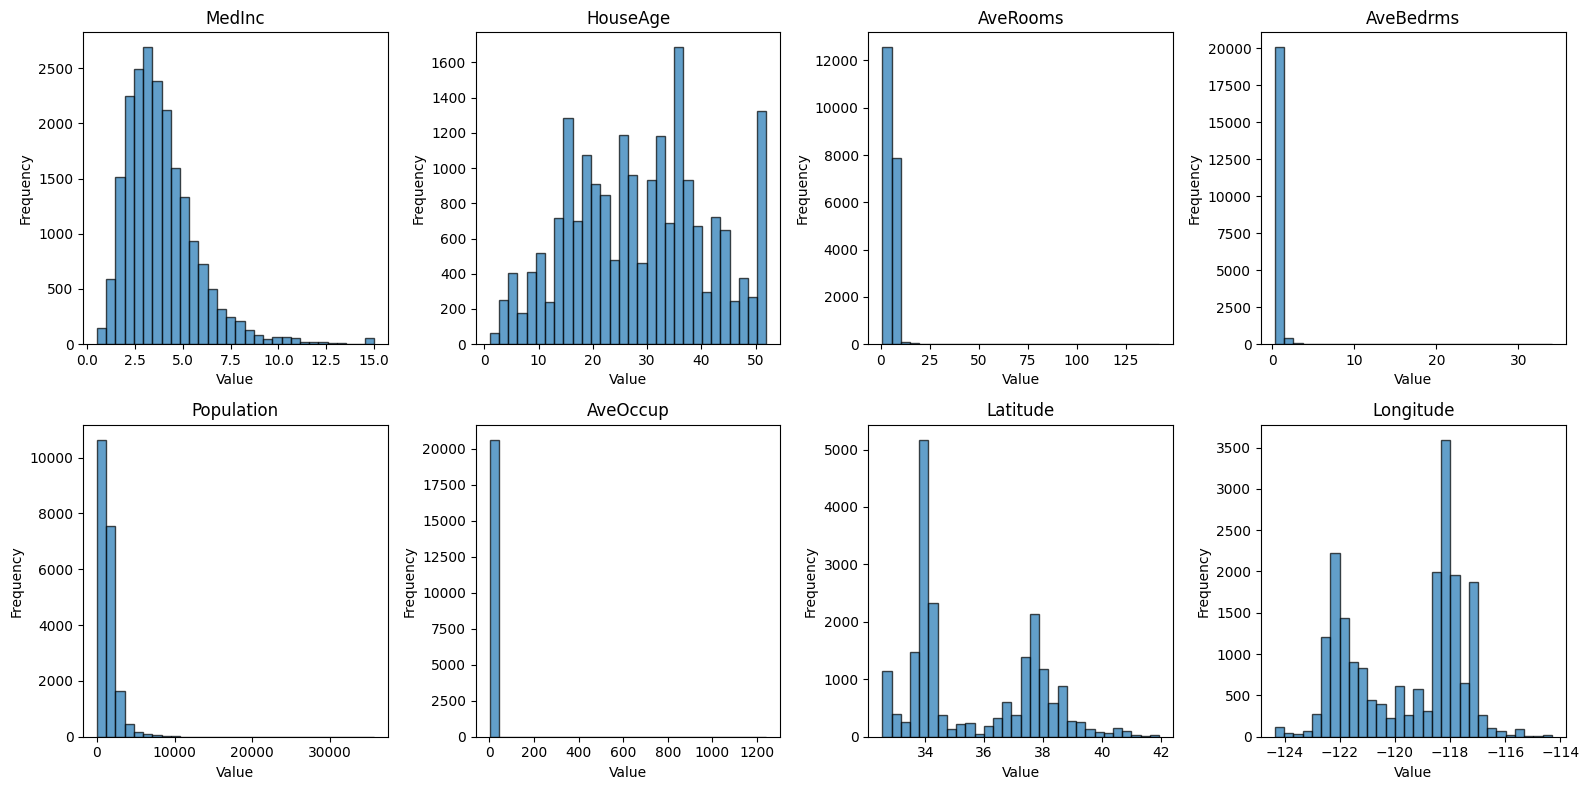

In [27]:
# STEP-2 FEATURES (Input Variables)
# Features are the input variables that describe each sample.
# Below is just looping through each input feature.
for i, feature in enumerate(X.columns):
    print(f"{i+1}. {feature}")
    print(f"   Mean: {X[feature].mean():.2f}, Std: {X[feature].std():.2f}")
# X.columns → list of feature names
# enumerate → gives: i → index (0,1,2…) and feature → column name

# Visualize feature distributions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
# Creates a grid of plots: 2 rows × 4 columns = 8 plots
# figsize controls plot size (bigger = clearer)
# Why 2×4?  Because there are 8 features
axes = axes.ravel()
for i, col in enumerate(X.columns):
    axes[i].hist(X[col], bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
plt.tight_layout() # Prevents overlapping labels and makes plots readable
#plt.savefig('pytorch_feature_distributions.png', dpi=100, bbox_inches='tight')
plt.show()

In [28]:
# STEP-3: TRAIN-TEST SPLIT
# Splitting data to train the model and evaluate its performance on unseen data.
# 80% data for training (learning)
# 20% data for testing (evaluation on unseen data)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
    random_state=42 # ensures same split every run
)
# Print dataset sizes for verification
print(f"Training set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Testing set size: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

Training set size: 16512 samples (80.0%)
Testing set size: 4128 samples (20.0%)


In [29]:
# STEP-4: FEATURE SCALING/NORMALIZATION
# Scaling features to have mean=0 and std=1 (Standardization)
# Feature scaling makes all input features speak the same “language” to the neural network.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Why NOT fit_transform here: Test data must be treated as unseen

In [30]:
# Step-5 TENSORS
# Tensors are PyTorch's version of arrays - the fundamental data structure.
# They're similar to NumPy arrays but can run on GPU for acceleration.
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test.values).to(device)

print(f"X_train tensor shape: {X_train_tensor.shape}")
print(f"X_train tensor device: {X_train_tensor.device}")
print(f"X_train tensor dtype: {X_train_tensor.dtype}")
print(f"\nTensors are now ready for GPU acceleration!" if device.type == 'cuda' else "\nTensors are on CPU")

X_train tensor shape: torch.Size([16512, 8])
X_train tensor device: cuda:0
X_train tensor dtype: torch.float32

Tensors are now ready for GPU acceleration!


In [31]:
#STEP-6: DATALOADER
# Create TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Batch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Batch size: 32
Number of training batches: 516
Number of test batches: 129


In [32]:
#STEP-7: BUILDING THE NEURAL NETWORK
# nn.Module:
# -nn.Module is PyTorch's base class for all neural network modules.
# -Our model will inherit from nn.Module.

# LAYERS:
# -Layers are the building blocks of neural networks.
# -nn.Linear creates fully connected (dense) layers.

#ACTIVATION FUNCTIONS:
# -Activation functions introduce non-linearity.
# -We'll use ReLU (Rectified Linear Unit) for hidden layers.

#FORWARD METHOD
#-The forward() method defines how data flows through the network.

class NeuralNetwork(nn.Module):
    """
    Custom Neural Network class inheriting from nn.Module
    """
    def __init__(self, input_size, hidden_sizes, output_size):
        """
        Initialize the neural network layers

        Args:
            input_size: Number of input features
            hidden_sizes: List of hidden layer sizes
            output_size: Number of output neurons
        """
        super(NeuralNetwork, self).__init__()

        # Input layer to first hidden layer
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.relu1 = nn.ReLU()

        # Second hidden layer
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu2 = nn.ReLU()

        # Third hidden layer
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.relu3 = nn.ReLU()

        # Output layer
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)

    def forward(self, x):
        """
        Forward propagation: Define how data flows through the network

        Args:
            x: Input tensor

        Returns:
            Output tensor (predictions)
        """
        # Pass through first hidden layer
        x = self.fc1(x)
        x = self.relu1(x)

        # Pass through second hidden layer
        x = self.fc2(x)
        x = self.relu2(x)

        # Pass through third hidden layer
        x = self.fc3(x)
        x = self.relu3(x)

        # Output layer (no activation for regression)
        x = self.fc4(x)

        return x

# Create model instance
input_size = X_train_scaled.shape[1]
hidden_sizes = [64, 32, 16]
output_size = 1

model = NeuralNetwork(input_size, hidden_sizes, output_size).to(device)

print("✓ Model created successfully!")
print("\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

✓ Model created successfully!

Model Architecture:
NeuralNetwork(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=16, out_features=1, bias=True)
)

Total parameters: 3,201


In [33]:
# Step-8  LOSS FUNCTION (Criterion)
# Loss function measures prediction errors.
# For regression, we use Mean Squared Error (MSE)
# MSE = average((predicted - actual)²)
criterion = nn.MSELoss()

In [34]:
# STEP-9 OPTIMIZER
# Optimizer updates model weights to minimize loss.
# We'll use Adam optimizer - adaptive learning rate method.
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [35]:
#STEP-10 TRAINING PROCESS
# A. EPOCH: One complete pass through training data
# B. FORWARD PROPAGATION: Computing predictions
# C. BACKPROPAGATION: Computing gradients
# D. WEIGHT UPDATE: Adjusting parameters based on gradients

# Training loop
epochs = 100
train_losses = []
val_losses = []

for epoch in range(epochs):
    # ========== TRAINING MODE ==========
    model.train()  # Set model to training mode
    train_loss = 0.0

    for batch_X, batch_y in train_loader:
        # FORWARD PROPAGATION
        # Pass data through the network
        predictions = model(batch_X).squeeze()

        # COMPUTE LOSS
        loss = criterion(predictions, batch_y)

        # BACKPROPAGATION
        # Zero gradients from previous step
        optimizer.zero_grad()

        # Compute gradients (backpropagation)
        loss.backward()

        # WEIGHT UPDATE
        # Update weights using optimizer
        optimizer.step()

        train_loss += loss.item()

    # Calculate average training loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # ========== VALIDATION MODE ==========
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation for validation
        for batch_X, batch_y in test_loader:
            predictions = model(batch_X).squeeze()
            loss = criterion(predictions, batch_y)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("\n Training completed")

Epoch [10/100] - Train Loss: 0.2963, Val Loss: 0.3185
Epoch [20/100] - Train Loss: 0.2766, Val Loss: 0.2936
Epoch [30/100] - Train Loss: 0.2630, Val Loss: 0.2823
Epoch [40/100] - Train Loss: 0.2567, Val Loss: 0.2918
Epoch [50/100] - Train Loss: 0.2478, Val Loss: 0.2751
Epoch [60/100] - Train Loss: 0.2393, Val Loss: 0.2761
Epoch [70/100] - Train Loss: 0.2313, Val Loss: 0.2629
Epoch [80/100] - Train Loss: 0.2285, Val Loss: 0.2655
Epoch [90/100] - Train Loss: 0.2195, Val Loss: 0.2751
Epoch [100/100] - Train Loss: 0.2164, Val Loss: 0.2814

 Training completed




 TRAINING VISUALIZATION


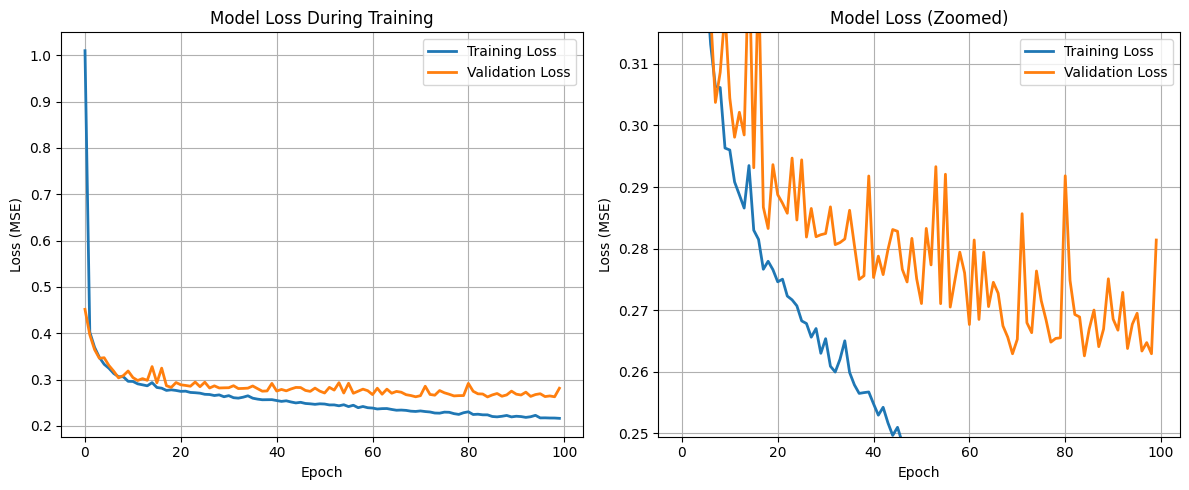

In [36]:
print("\n\n TRAINING VISUALIZATION")
print("=" * 80)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss During Training')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss (Zoomed)')
plt.ylim([min(val_losses) * 0.95, min(val_losses) * 1.2])
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('pytorch_training_history.png', dpi=100, bbox_inches='tight')
plt.show()


In [37]:
# STEP-11 INFERENCE/PREDICTION
# Using the trained model to make predictions on test data.
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).squeeze().cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()

print(f"Predictions on first 5 test samples:")
for i in range(5):
    print(f"  Actual: ${y_test_np[i]*100000:.0f}, Predicted: ${y_pred[i]*100000:.0f}")


Predictions on first 5 test samples:
  Actual: $47700, Predicted: $56441
  Actual: $45800, Predicted: $90078
  Actual: $500001, Predicted: $486186
  Actual: $218600, Predicted: $245784
  Actual: $278000, Predicted: $228960


1. Mean Squared Error (MSE): 0.2814
   Average of squared errors

2. Root Mean Squared Error (RMSE): 0.5305
   Average error: $53047

3. Mean Absolute Error (MAE): 0.3492
   Average absolute error: $34922

4. R² Score: 0.7853
   Proportion of variance explained (1.0 = perfect)


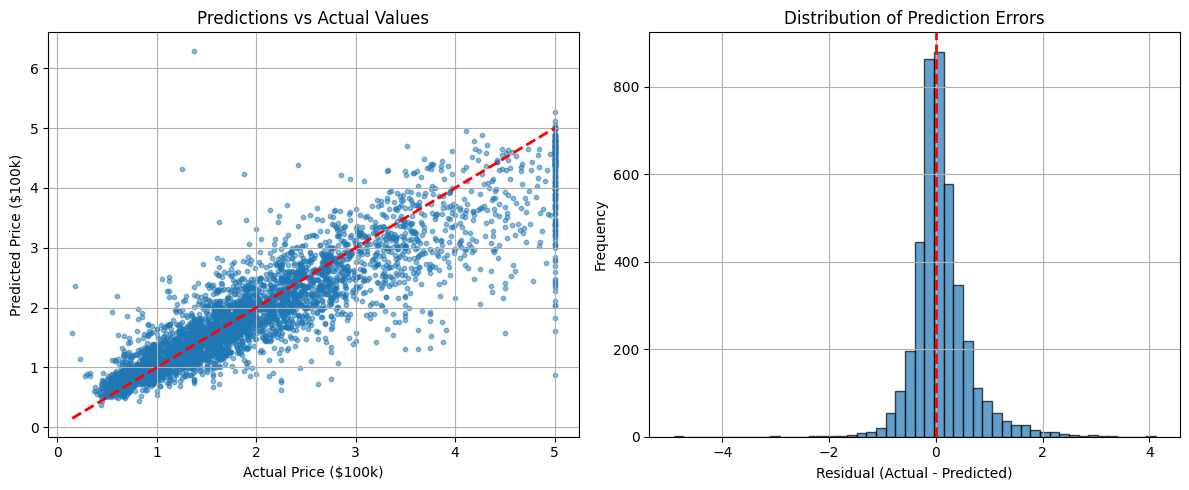

In [39]:
# STEP-12 EVALUATION METRICS
mse = mean_squared_error(y_test_np, y_pred)
mae = mean_absolute_error(y_test_np, y_pred)
r2 = r2_score(y_test_np, y_pred)
rmse = np.sqrt(mse)

print(f"1. Mean Squared Error (MSE): {mse:.4f}")
print(f"   Average of squared errors")
print()
print(f"2. Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"   Average error: ${rmse*100000:.0f}")
print()
print(f"3. Mean Absolute Error (MAE): {mae:.4f}")
print(f"   Average absolute error: ${mae*100000:.0f}")
print()
print(f"4. R² Score: {r2:.4f}")
print(f"   Proportion of variance explained (1.0 = perfect)")

# Visualize predictions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_np, y_pred, alpha=0.5, s=10)
plt.plot([y_test_np.min(), y_test_np.max()],
         [y_test_np.min(), y_test_np.max()], 'r--', lw=2)
plt.xlabel('Actual Price ($100k)')
plt.ylabel('Predicted Price ($100k)')
plt.title('Predictions vs Actual Values')
plt.grid(True)

plt.subplot(1, 2, 2)
residuals = y_test_np - y_pred
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.axvline(0, color='r', linestyle='--', linewidth=2)
plt.grid(True)

plt.tight_layout()
plt.savefig('pytorch_model_evaluation.png', dpi=100, bbox_inches='tight')
plt.show()

In [40]:
# STEP-13 MODEL PARAMETERS
# Parameters are the learned weights and biases.
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print()
print("Parameter breakdown by layer:")
for name, param in model.named_parameters():
    print(f"  {name}: {param.numel():,} parameters, shape: {param.shape}")


Total parameters: 3,201
Trainable parameters: 3,201

Parameter breakdown by layer:
  fc1.weight: 512 parameters, shape: torch.Size([64, 8])
  fc1.bias: 64 parameters, shape: torch.Size([64])
  fc2.weight: 2,048 parameters, shape: torch.Size([32, 64])
  fc2.bias: 32 parameters, shape: torch.Size([32])
  fc3.weight: 512 parameters, shape: torch.Size([16, 32])
  fc3.bias: 16 parameters, shape: torch.Size([16])
  fc4.weight: 16 parameters, shape: torch.Size([1, 16])
  fc4.bias: 1 parameters, shape: torch.Size([1])


In [47]:
# STEP-14  SAVE THE MODEL
import joblib
import json
# Method 1: Save entire model
torch.save(model, 'pytorch_model_complete.pth')
print("✓ Method 1: Complete model saved to 'pytorch_model_complete.pth'")

# Method 2: Save only state dict (recommended)
torch.save(model.state_dict(), 'pytorch_model_weights.pth')
print("✓ Method 2: Model weights saved to 'pytorch_model_weights.pth'")

# Method 3: Save checkpoint with additional info
checkpoint = {
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses[-1],
    'val_loss': val_losses[-1]
}
torch.save(checkpoint, 'pytorch_checkpoint.pth')

# Save scaler
joblib.dump(scaler, 'scaler.pkl')
print("✓ Scaler saved: scaler.pkl")




✓ Method 1: Complete model saved to 'pytorch_model_complete.pth'
✓ Method 2: Model weights saved to 'pytorch_model_weights.pth'
✓ Scaler saved: scaler.pkl


In [50]:
from google.colab import files

# Download model files
files.download('pytorch_model_complete.pth')
files.download('scaler.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>